In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np

import torch
import tqdm

# from ray import tune

import stable_baselines3
from stable_baselines3.common import vec_env, monitor


import autonomous_optimizer
import benchmark

First, open up a terminal window and run
```bash
$ tensorboard --logdir tb_logs
```

Then open up the tensorboard interface, usually at [http://localhost:6006](http://localhost:6006)



## Convex Quadratics

First, we will examine performance on convex quadratic objective functions. We generate 90 convex quadratics in two dimensions with eigenvalues uniformly distributed between 1 and 30 as the train set.

In [3]:
quadratic_dataset = [benchmark.convex_quadratic() for _ in range(90)]

Now we define the RL environment and our model.

In [4]:
quadratic_env = vec_env.DummyVecEnv([
    lambda: monitor.Monitor(
        autonomous_optimizer.Environment(quadratic_dataset, num_steps=40, history_len=25)
    )
]*32)

quadratic_policy = stable_baselines3.PPO('MlpPolicy', quadratic_env, n_steps=2, verbose=0,
                                         tensorboard_log='tb_logs/quadratic')

Train the algorithm on 20 passes over the dataset

In [5]:
quadratic_policy.learn(total_timesteps=50 * quadratic_env.envs[0].num_steps * len(quadratic_dataset))

We will be comparing the RL optimizer to several common convex optimization algorithms. We use Bayesian optimization to find good hyperparameters for this class of problems. And to make this a fair comparison, we will also run 20 passes over all problems in the dataset, just like the RL algorithm gets.

In [6]:
quadratic_tune = {
    "sgd": {"hyperparams": {"lr": 5e-2}},
    "momentum": {"hyperparams": {"lr": 1e-2, "momentum": 0.7}},
    "adam": {"hyperparams": {"lr": 1e-1}},
    "lbfgs": {"hyperparams": {"lr": 1, "max_iter": 1}}
}

Now, let's compare their behavior on an example problem.

In [11]:
problem = benchmark.convex_quadratic()

model0 = problem["model0"]
obj_function = problem["obj_function"]
optimal_x = problem["optimal_x"]
optimal_value = problem["optimal_val"]
A = problem["A"]
b = problem["b"]
    
print(f'Objective function minimum: {optimal_value}')

Objective function minimum: -0.04889146238565445


Run algos with our tuned hyperparams

In [12]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, quadratic_tune, quadratic_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

SGD best loss: -0.048891469836235046
Momentum best loss: -0.048890452831983566
Adam best loss: -0.04878697916865349
LBFGS best loss: -0.04889146238565445
Autonomous Optimizer best loss: -0.048445992171764374


Distance from optimal vs iteration

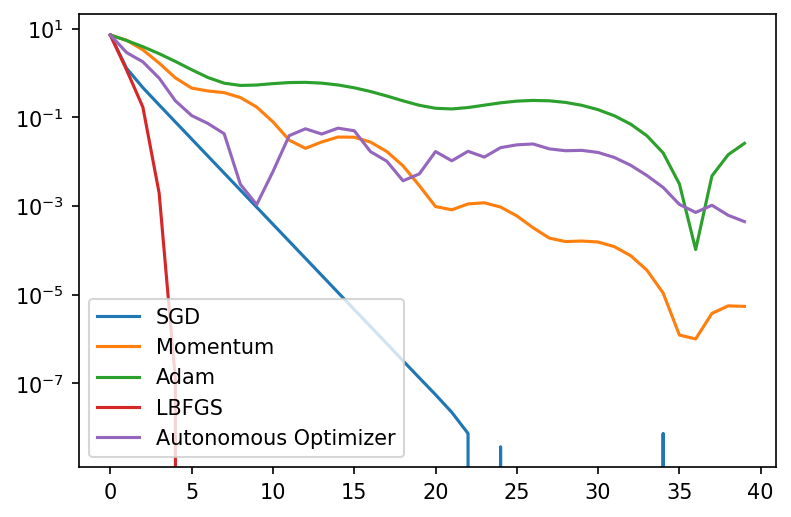

In [13]:
plt.figure(figsize=(6, 4), dpi=150)

plt.plot(sgd_vals - optimal_value, label='SGD')
plt.plot(momentum_vals - optimal_value, label='Momentum')
plt.plot(adam_vals - optimal_value, label='Adam')
plt.plot(lbfgs_vals - optimal_value, label='LBFGS')
plt.plot(ao_vals - optimal_value, label='Autonomous Optimizer')

plt.yscale('log')
plt.legend()
plt.show()

Plotting trajectories on a 2-D slice of the parameter space

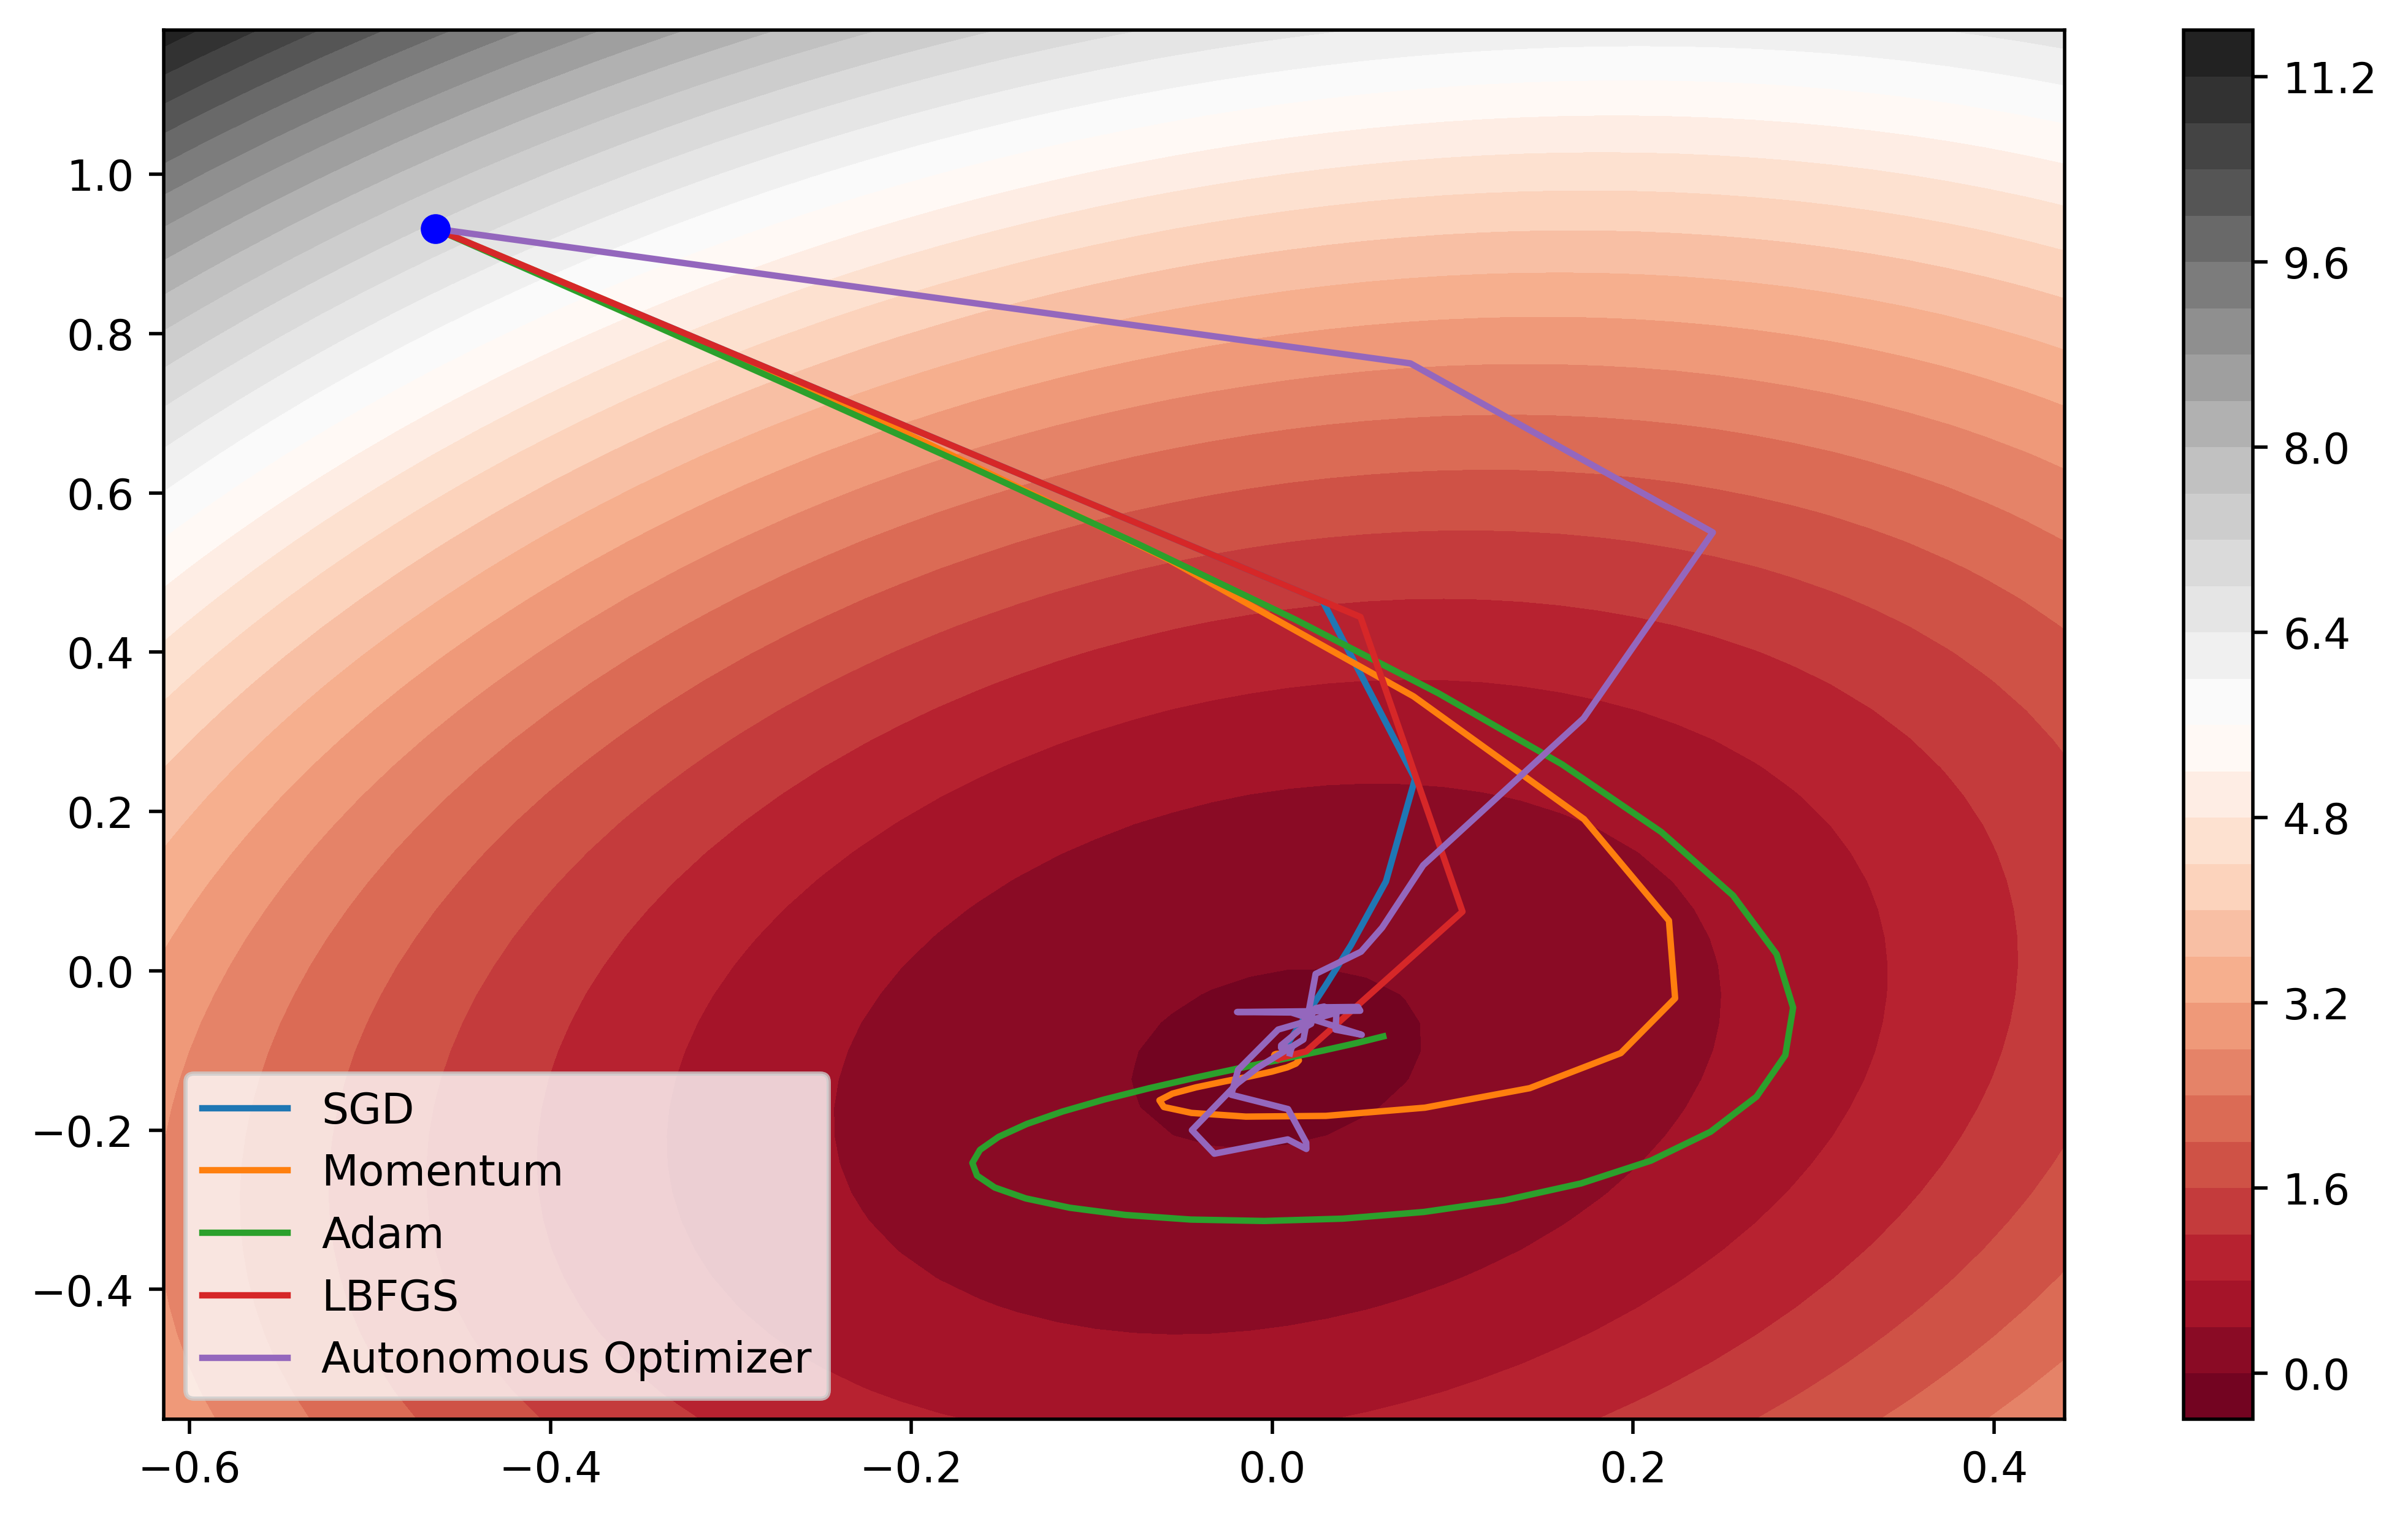

In [14]:
def get_weights(model):
    return model.x[0].item(), model.x[1].item()

def set_weights(model, w1, w2):
    model.x[0] = w1
    model.x[1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)

## Logistic Regression

In [46]:
lr_dataset = [benchmark.logistic_regression() for _ in range(90)]

In [47]:
lr_env = vec_env.DummyVecEnv([
    lambda: monitor.Monitor(
        autonomous_optimizer.Environment(lr_dataset, num_steps=40, history_len=25)
    )
]*32)

lr_policy = stable_baselines3.PPO('MlpPolicy', lr_env, n_steps=2, verbose=0,
                                  tensorboard_log='tb_logs/lr')

In [48]:
lr_policy.learn(total_timesteps=50 * lr_env.envs[0].num_steps * len(lr_dataset))

In [68]:
lr_tune = {
    "sgd": {"hyperparams": {"lr": 1e-1}},
    "momentum": {"hyperparams": {"lr": 5e-1, "momentum": 0.85}},
    "adam": {"hyperparams": {"lr": 5e-1}},
    "lbfgs": {"hyperparams": {"lr": 1, "max_iter": 1}}
}

In [60]:
problem = benchmark.logistic_regression()

model0 = problem["model0"]
obj_function = problem["obj_function"]
x, y = problem["data"]

In [69]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, lr_tune, lr_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

sgd_accuracy = np.array([benchmark.accuracy(model, x, y) for model in sgd_traj])
momentum_accuracy = np.array([benchmark.accuracy(model, x, y) for model in momentum_traj])
adam_accuracy = np.array([benchmark.accuracy(model, x, y) for model in adam_traj])
lbfgs_accuracy = np.array([benchmark.accuracy(model, x, y) for model in lbfgs_traj])
ao_accuracy = np.array([benchmark.accuracy(model, x, y) for model in ao_traj])

print(f'\nSGD best accuracy: {sgd_accuracy.max()}')
print(f'Momentum best accuracy: {momentum_accuracy.max()}')
print(f'Adam best accuracy: {adam_accuracy.max()}')
print(f'LBFGS best accuracy: {lbfgs_accuracy.max()}')
print(f'Autonomous optimizer best accuracy: {ao_accuracy.max()}')

SGD best loss: 0.5891268849372864
Momentum best loss: 0.3446229100227356
Adam best loss: 0.19421197474002838
LBFGS best loss: 0.11914395540952682
Autonomous Optimizer best loss: 0.30591627955436707

SGD best accuracy: 0.7200000286102295
Momentum best accuracy: 0.9100000262260437
Adam best accuracy: 0.9599999785423279
LBFGS best accuracy: 0.9700000286102295
Autonomous optimizer best accuracy: 0.949999988079071


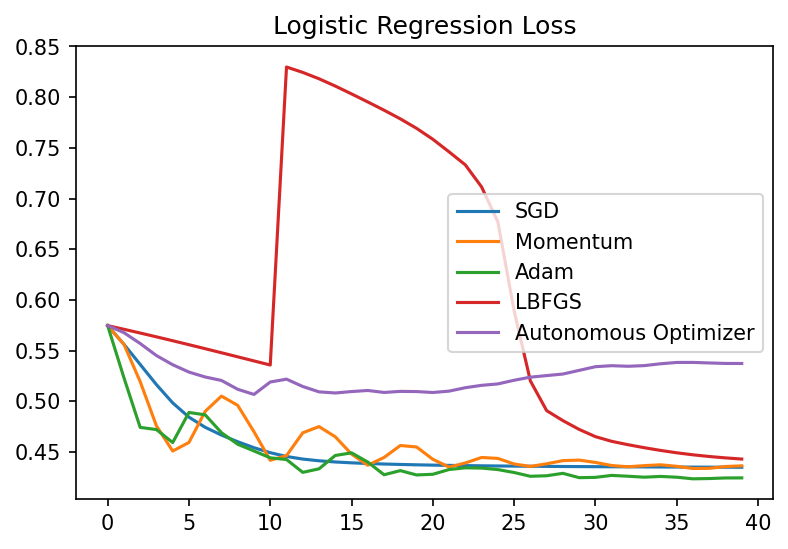

In [101]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('Logistic Regression Loss')
plt.plot(sgd_vals, label='SGD')
plt.plot(momentum_vals, label='Momentum')
plt.plot(adam_vals, label='Adam')
plt.plot(lbfgs_vals, label='LBFGS')
plt.plot(ao_vals, label='Autonomous Optimizer')

plt.legend()
plt.show()

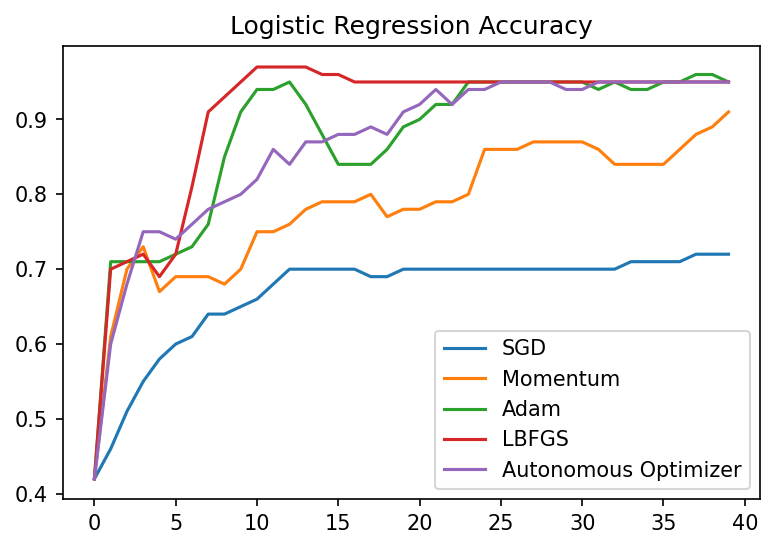

In [104]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('Logistic Regression Accuracy')
plt.plot(sgd_accuracy, label='SGD')
plt.plot(momentum_accuracy, label='Momentum')
plt.plot(adam_accuracy, label='Adam')
plt.plot(lbfgs_accuracy, label='LBFGS')
plt.plot(ao_accuracy, label='Autonomous Optimizer')

plt.legend()
plt.show()

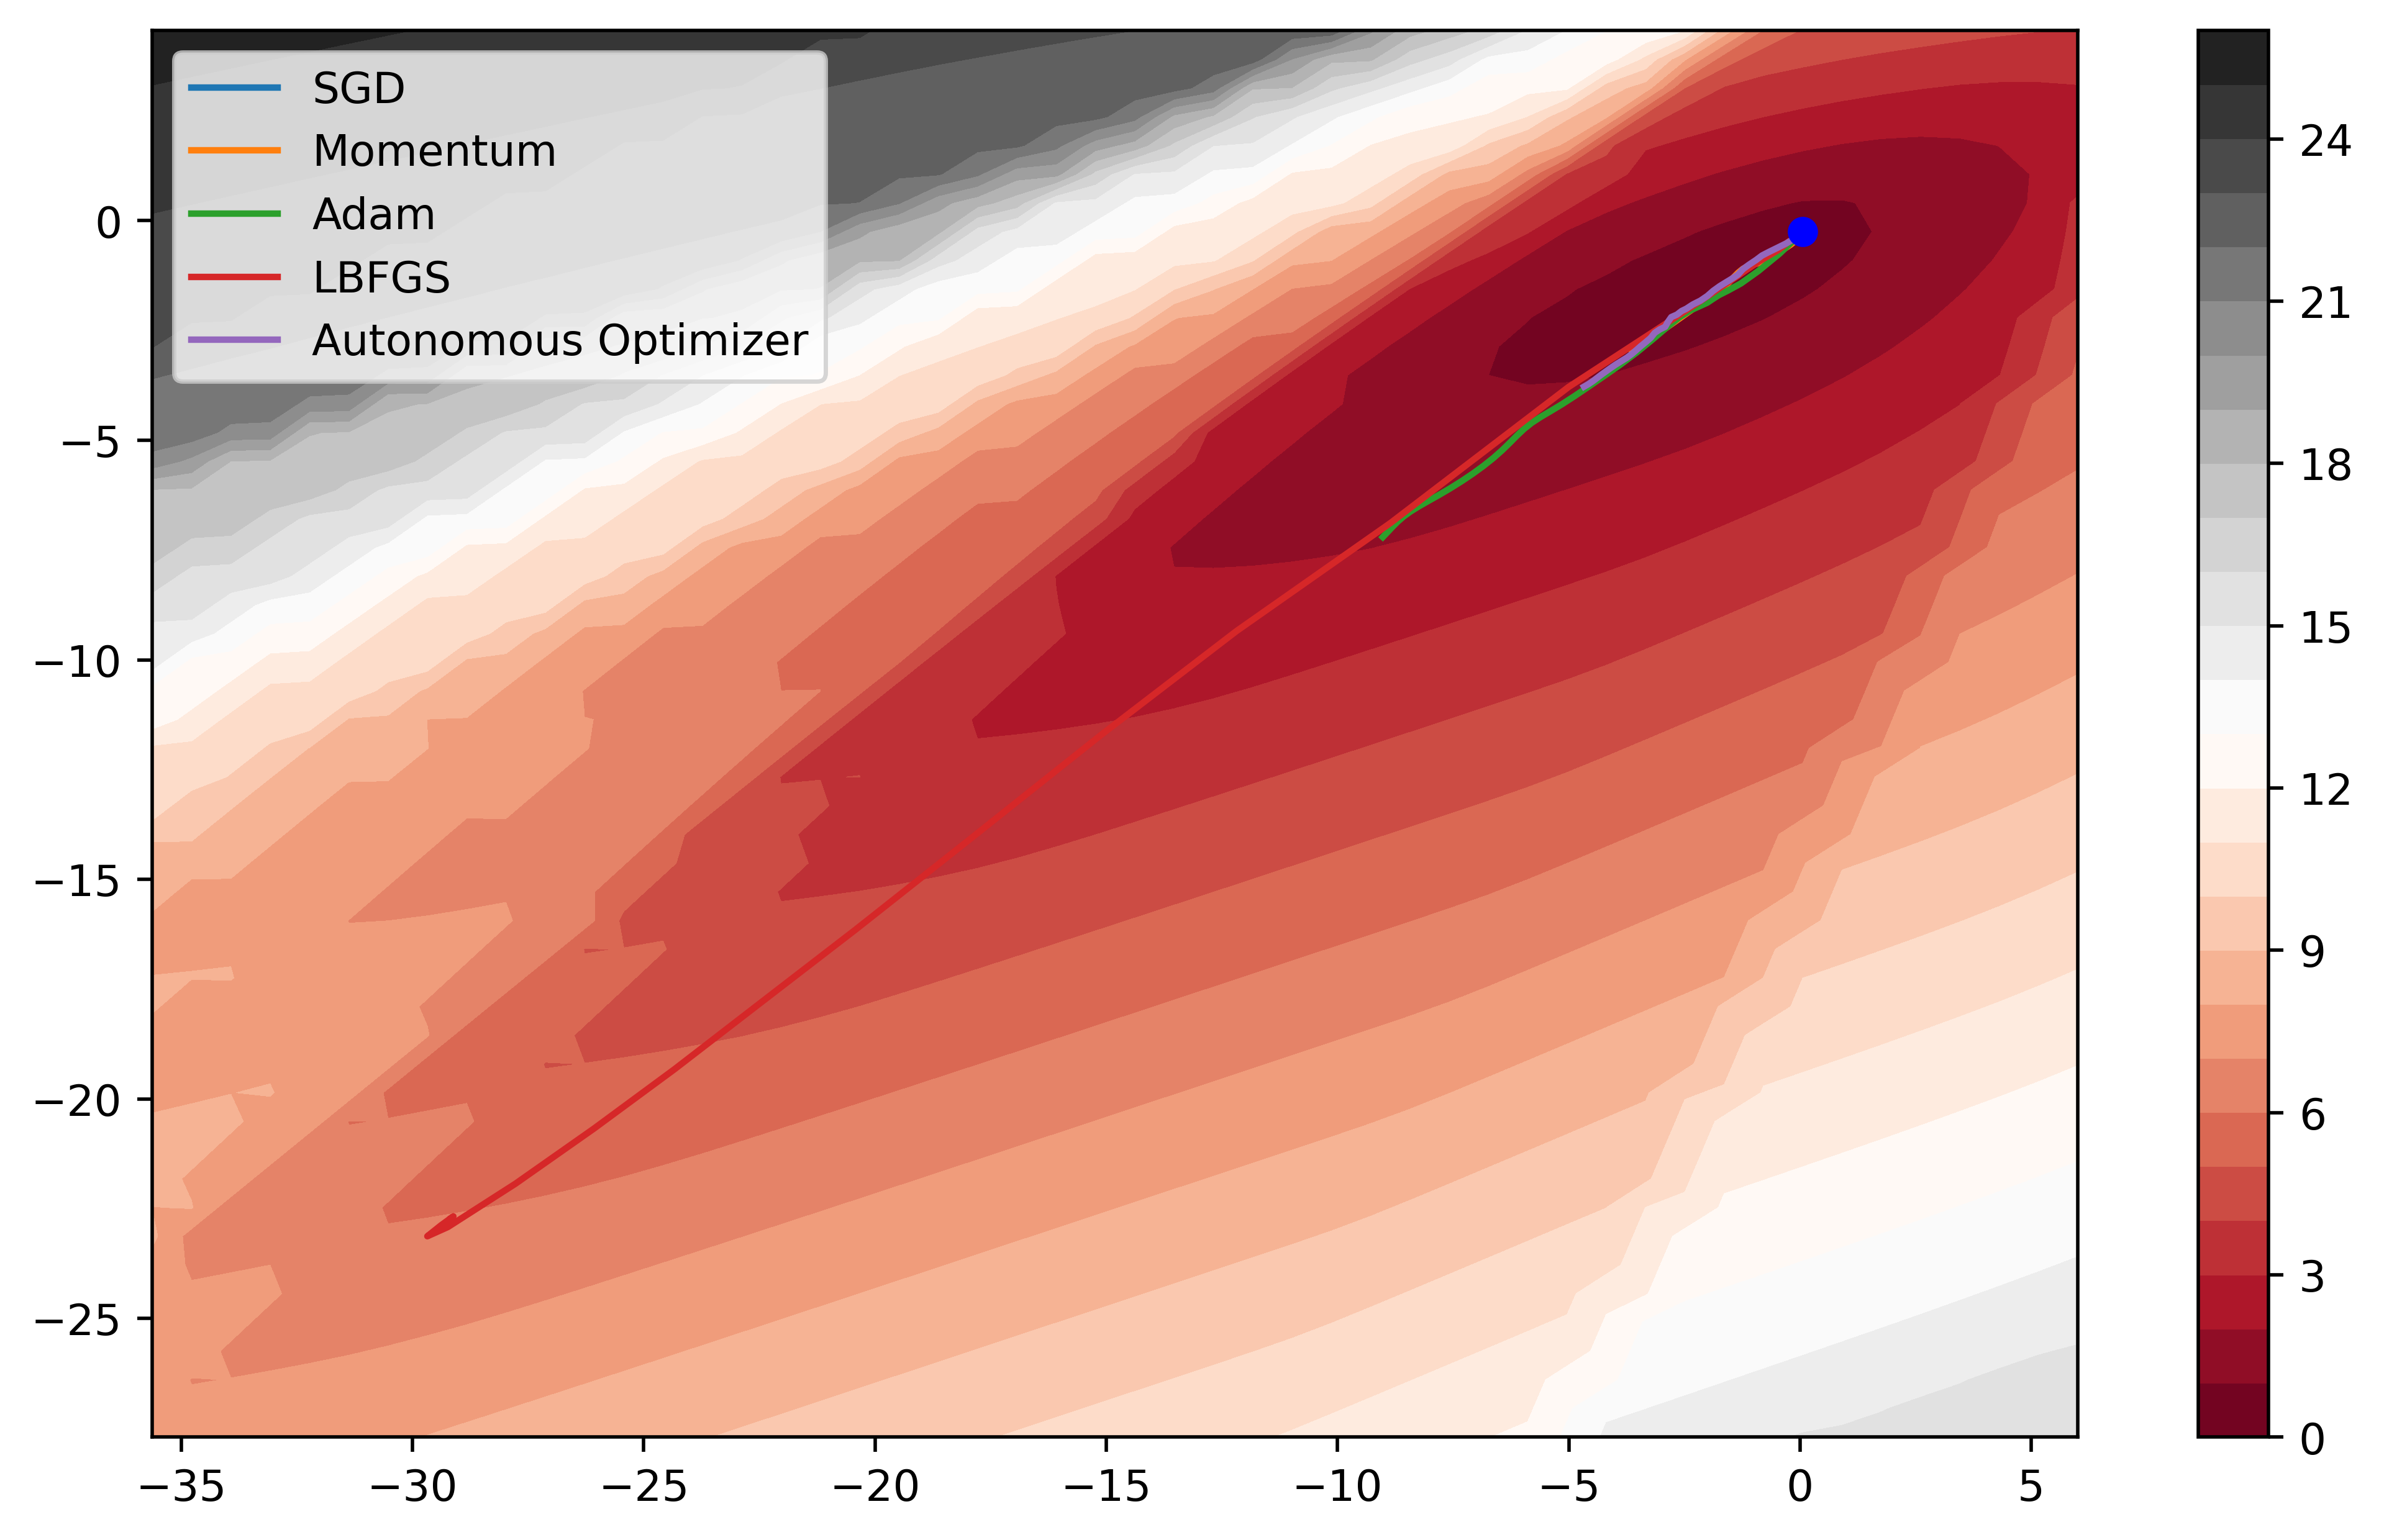

In [71]:
def get_weights(model):
    return model[0].weight[0, 0].item(), model[0].weight[0, 1].item()

def set_weights(model, w1, w2):
    model[0].weight[0, 0] = w1
    model[0].weight[0, 1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)

## Robust Linear Regression

In [164]:
rlr_dataset = [benchmark.robust_linear_regression() for _ in range(120)]

In [165]:
rlr_env = vec_env.DummyVecEnv([
    lambda: monitor.Monitor(
        autonomous_optimizer.Environment(rlr_dataset, num_steps=40, history_len=25)
    )
]*32)

rlr_policy = stable_baselines3.A2C('MlpPolicy', rlr_env, n_steps=2, verbose=0,
                                   tensorboard_log='tb_logs/rlr')

In [166]:
rlr_policy.learn(total_timesteps=125 * rlr_env.envs[0].num_steps * len(rlr_dataset))

In [167]:
rlr_tune = {
    "sgd": {"hyperparams": {"lr": 5e-1}},
    "momentum": {"hyperparams": {"lr": 5e-1, "momentum": 0.9}},
    "adam": {"hyperparams": {"lr": 5e-1}},
    "lbfgs": {"hyperparams": {"lr": 0.1, "max_iter": 1}}
}

In [168]:
problem = benchmark.robust_linear_regression()

model0 = problem["model0"]
obj_function = problem["obj_function"]

In [169]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, rlr_tune, rlr_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

SGD best loss: 0.4879506826400757
Momentum best loss: 0.4892936050891876
Adam best loss: 0.4892595410346985
LBFGS best loss: 0.5785189270973206
Autonomous Optimizer best loss: 0.49114203453063965


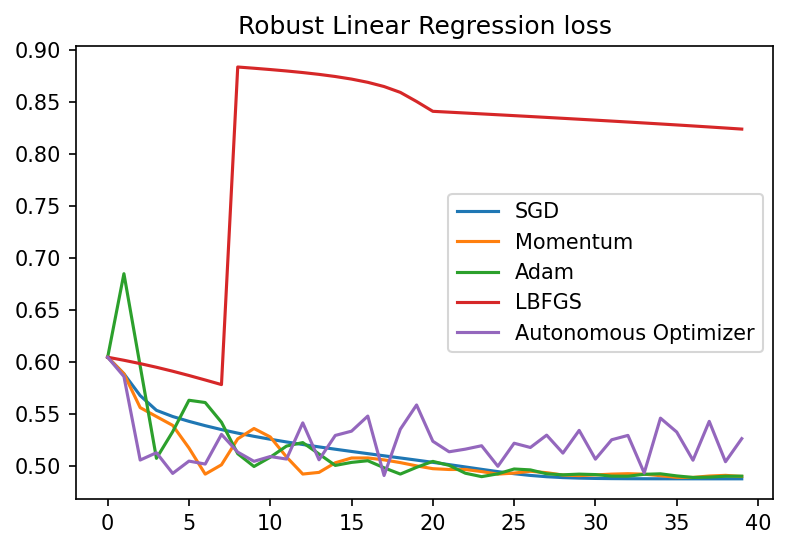

In [170]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('Robust Linear Regression loss')
plt.plot(sgd_vals, label='SGD')
plt.plot(momentum_vals, label='Momentum')
plt.plot(adam_vals, label='Adam')
plt.plot(lbfgs_vals, label='LBFGS')
plt.plot(ao_vals, label='Autonomous Optimizer')

plt.legend()
plt.show()

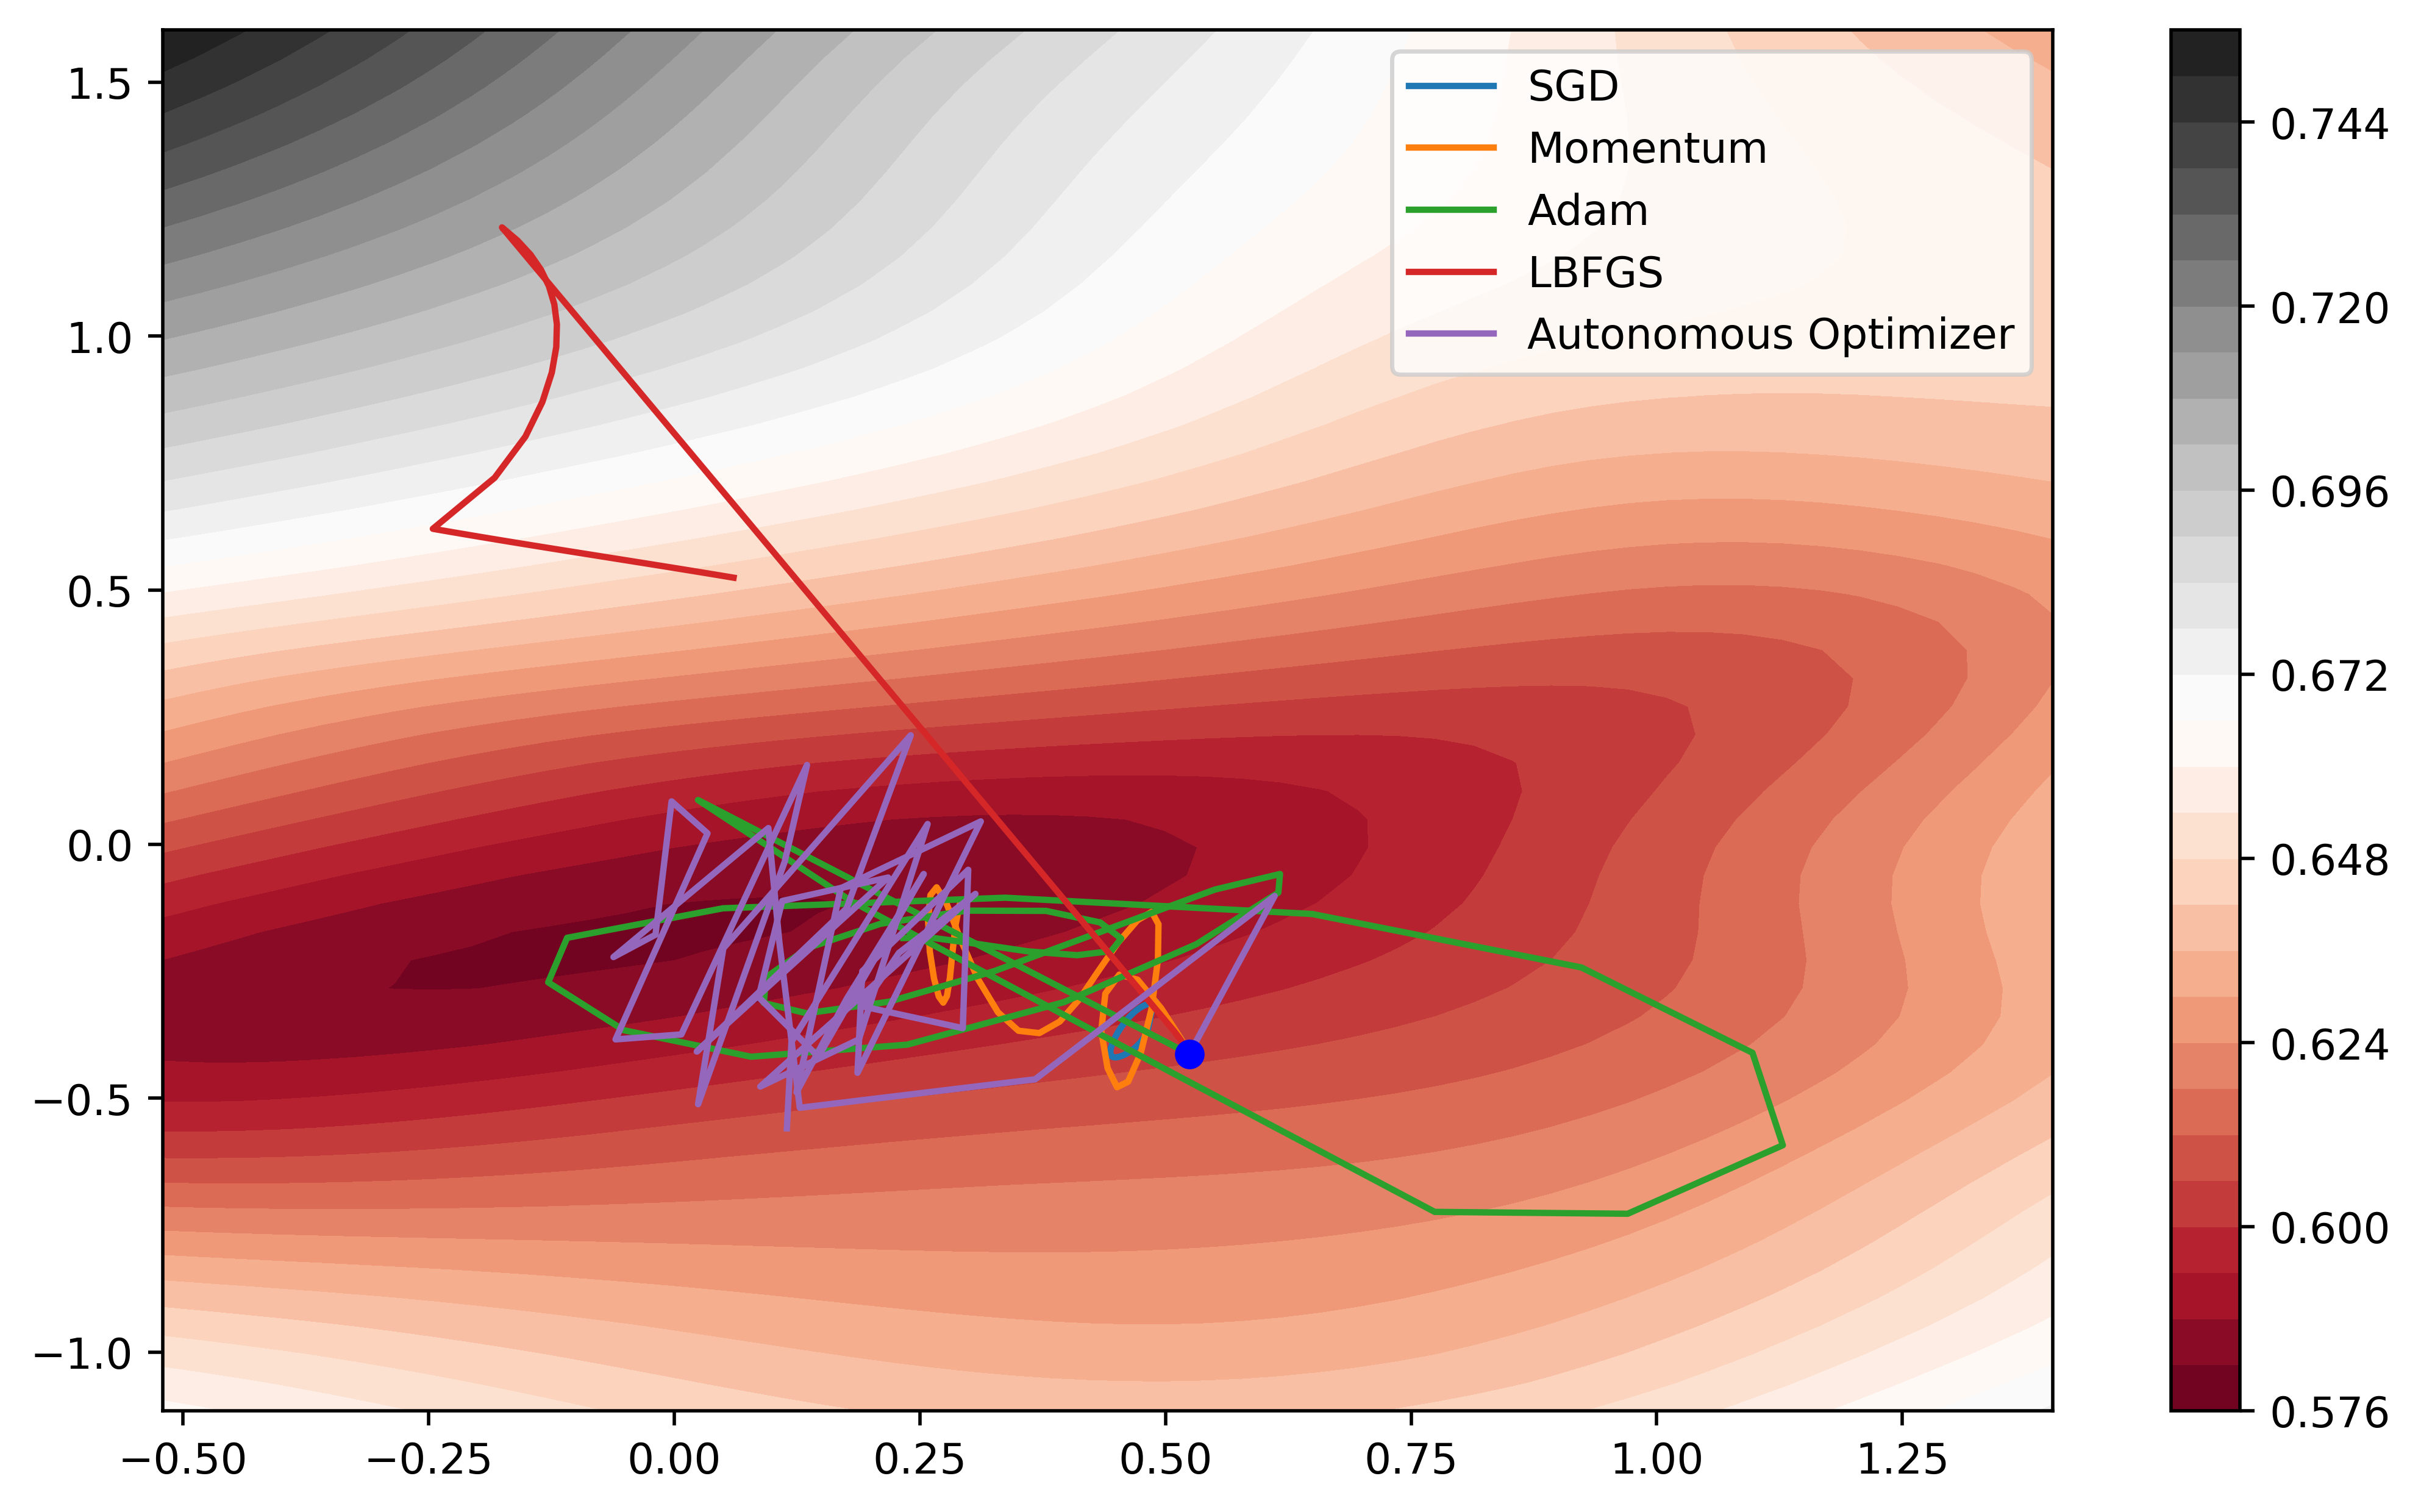

In [171]:
def get_weights(model):
    return model.weight[0, 0].item(), model.weight[0, 1].item()

def set_weights(model, w1, w2):
    model.weight[0, 0] = w1
    model.weight[0, 1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)

## Optimizing a 2-layer neural net

In [172]:
mlp_dataset = [benchmark.mlp() for _ in range(80)]

In [267]:
mlp_env = vec_env.DummyVecEnv([
    lambda: monitor.Monitor(
        autonomous_optimizer.Environment(mlp_dataset, num_steps=40, history_len=25)
    )
]*4)

mlp_policy = stable_baselines3.A2C('MlpPolicy', mlp_env, n_steps=2, verbose=0,
                                   tensorboard_log='tb_logs/mlp')

In [268]:
mlp_policy.learn(total_timesteps=20 * mlp_env.envs[0].num_steps * len(mlp_dataset))

In [263]:
mlp_tune = {
    "sgd": {"hyperparams": {"lr": 3e-1}},
    "momentum": {"hyperparams": {"lr": 3e-1, "momentum": 0.9}},
    "adam": {"hyperparams": {"lr": 5e-1}},
    "lbfgs": {"hyperparams": {"lr": 0.1, "max_iter": 1}}
}

In [264]:
problem = benchmark.mlp()

model0 = problem["model0"]
obj_function = problem["obj_function"]
x, y = problem["dataset"]

In [265]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, mlp_tune, mlp_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

sgd_accuracy = np.array([benchmark.accuracy(model, x, y) for model in sgd_traj])
momentum_accuracy = np.array([benchmark.accuracy(model, x, y) for model in momentum_traj])
adam_accuracy = np.array([benchmark.accuracy(model, x, y) for model in adam_traj])
lbfgs_accuracy = np.array([benchmark.accuracy(model, x, y) for model in lbfgs_traj])
ao_accuracy = np.array([benchmark.accuracy(model, x, y) for model in ao_traj])

print(f'\nSGD best accuracy: {sgd_accuracy.max()}')
print(f'Momentum best accuracy: {momentum_accuracy.max()}')
print(f'Adam best accuracy: {adam_accuracy.max()}')
print(f'LBFGS best accuracy: {lbfgs_accuracy.max()}')
print(f'Autonomous optimizer best accuracy: {ao_accuracy.max()}')

SGD best loss: 0.20928704738616943
Momentum best loss: 0.08746672421693802
Adam best loss: 0.02367844432592392
LBFGS best loss: 0.08765123784542084
Autonomous Optimizer best loss: 0.5850555896759033

SGD best accuracy: 0.9599999785423279
Momentum best accuracy: 0.9800000190734863
Adam best accuracy: 1.0
LBFGS best accuracy: 0.9700000286102295
Autonomous optimizer best accuracy: 0.5


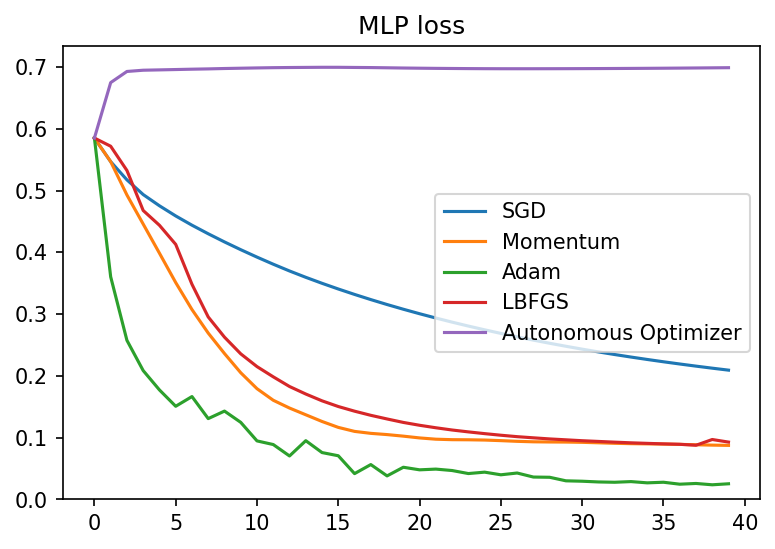

In [266]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('MLP loss')
plt.plot(sgd_vals, label='SGD')
plt.plot(momentum_vals, label='Momentum')
plt.plot(adam_vals, label='Adam')
plt.plot(lbfgs_vals, label='LBFGS')
plt.plot(ao_vals, label='Autonomous Optimizer')

if lbfgs_vals.max() > 1.5:
    plt.ylim(0, 1.1)
else:
    plt.ylim(0)

plt.legend()
plt.show()

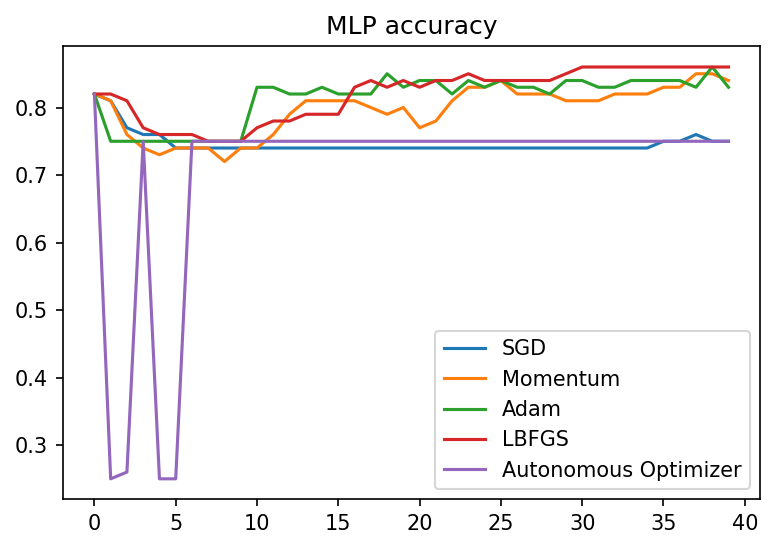

In [260]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('MLP accuracy')
plt.plot(sgd_accuracy, label='SGD')
plt.plot(momentum_accuracy, label='Momentum')
plt.plot(adam_accuracy, label='Adam')
plt.plot(lbfgs_accuracy, label='LBFGS')
plt.plot(ao_accuracy, label='Autonomous Optimizer')

plt.legend()
plt.show()

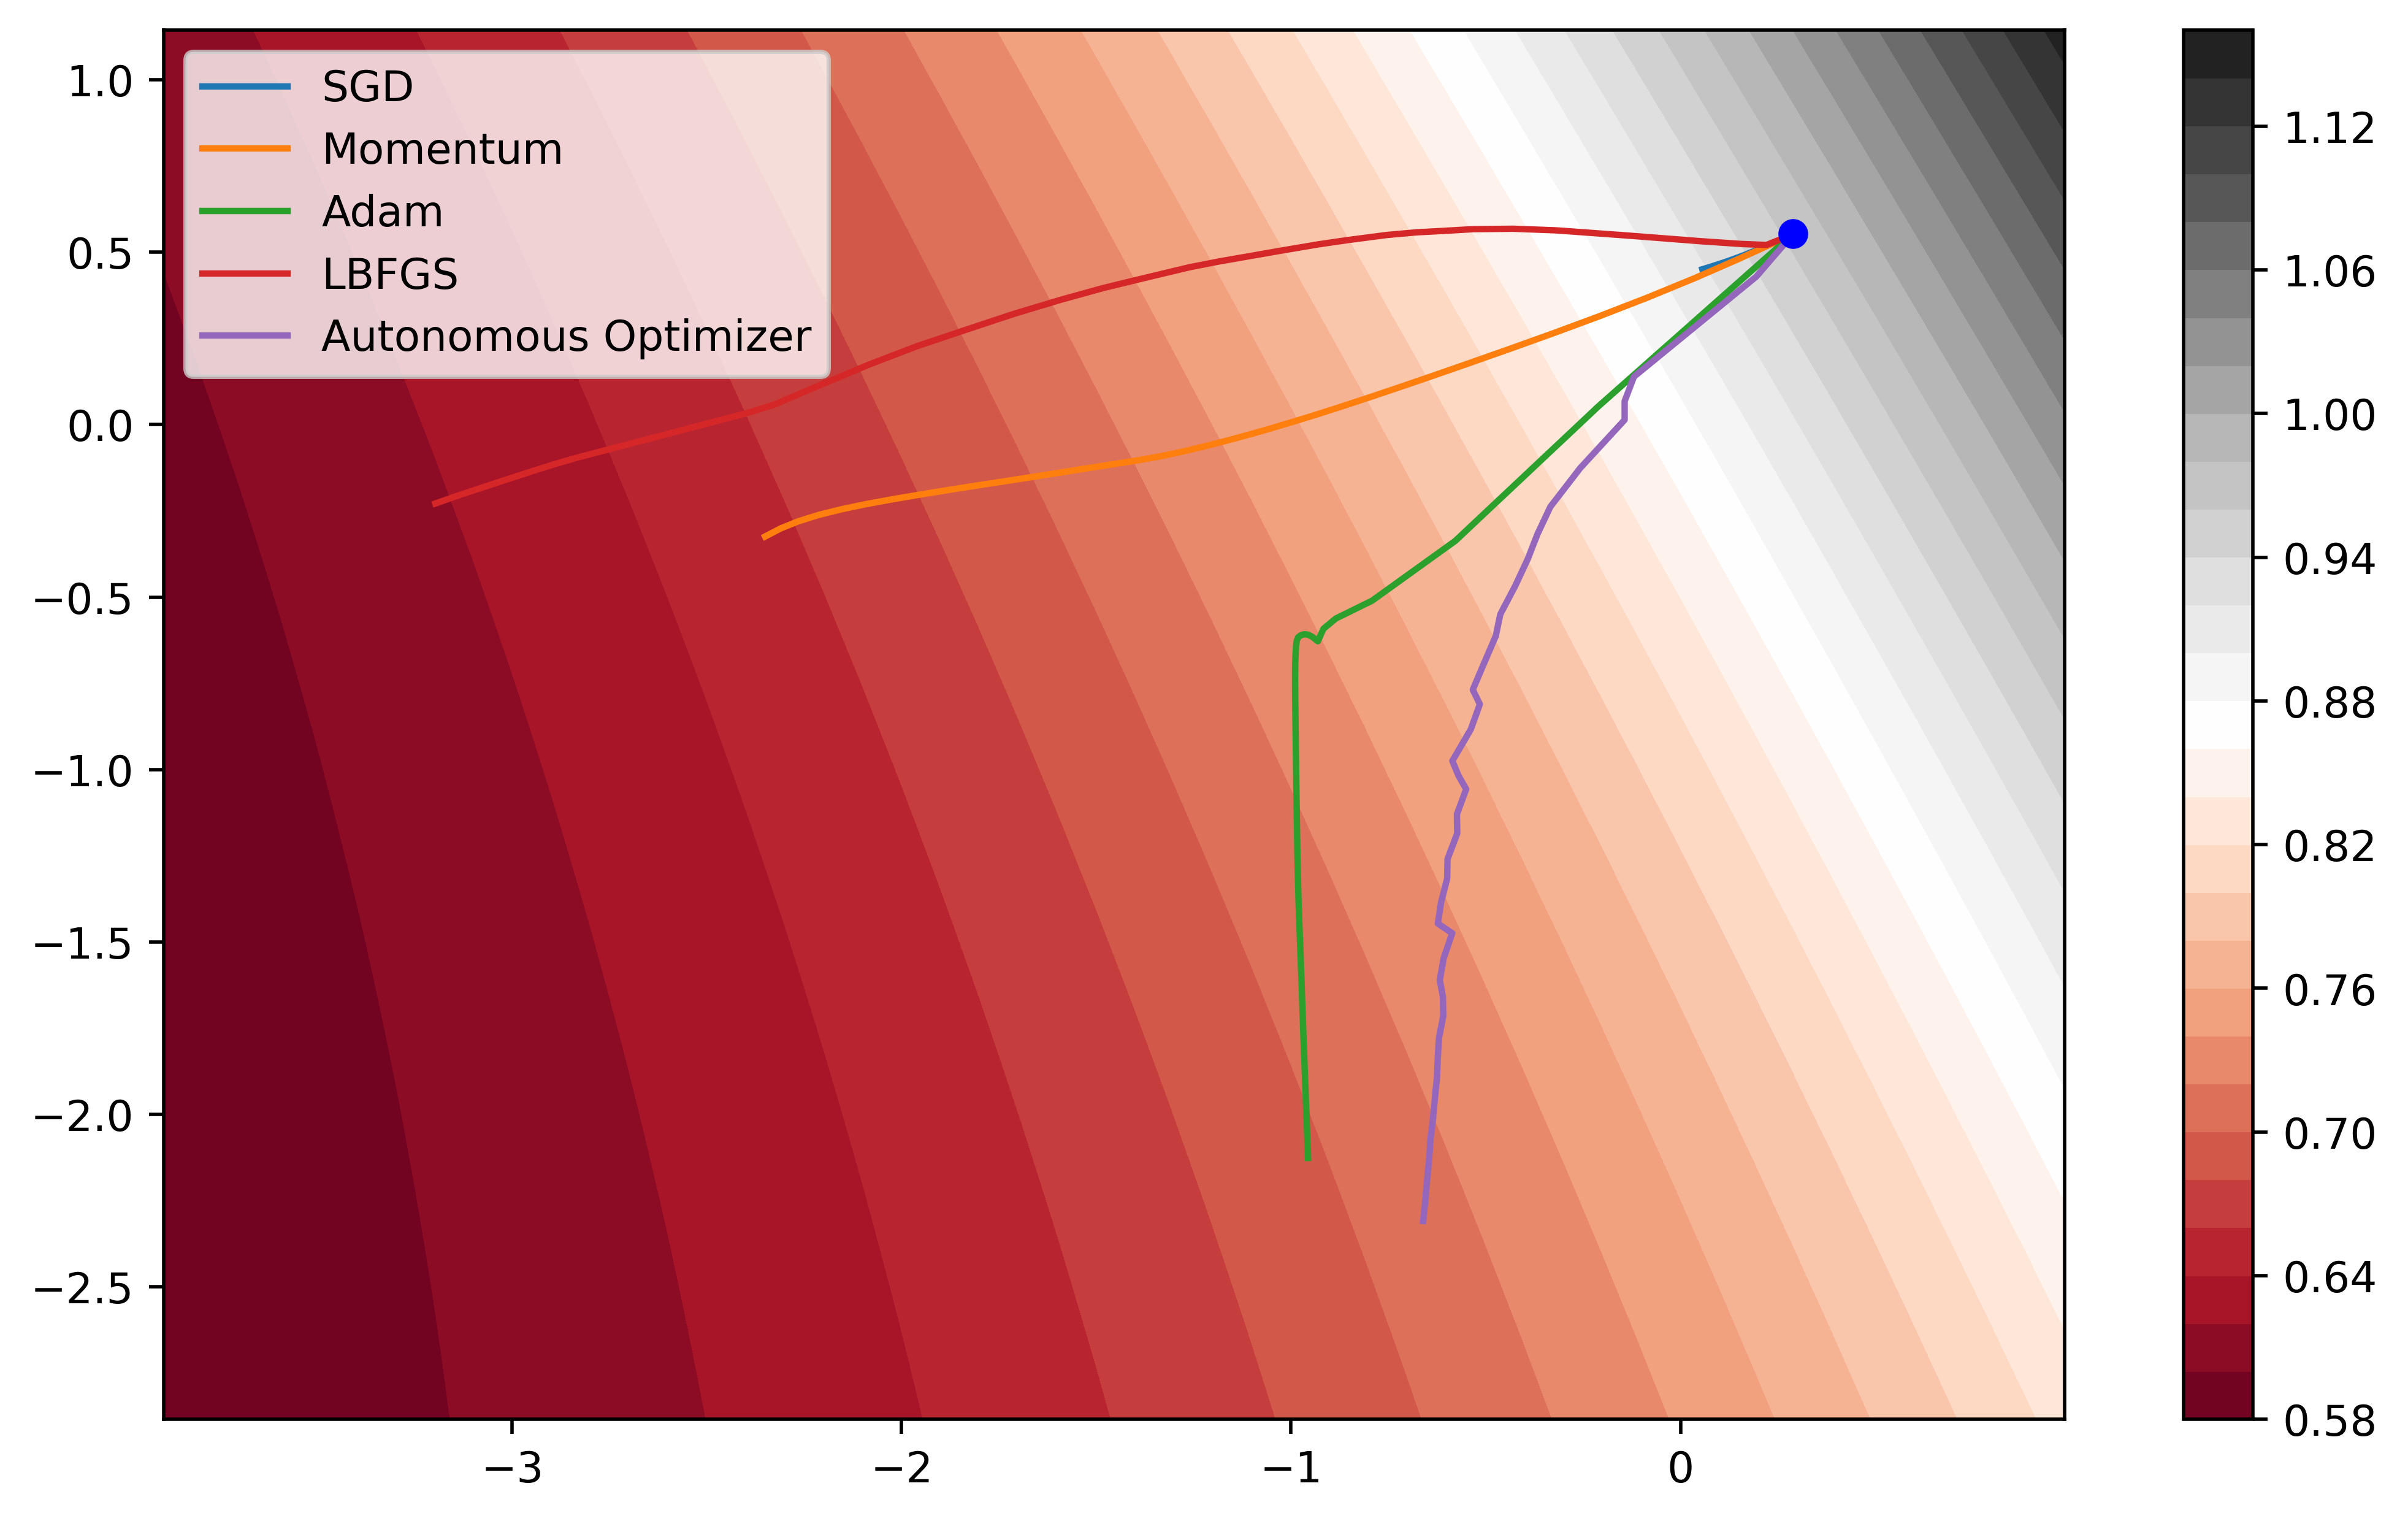

In [255]:
def get_weights(model):
    return model[2].weight[0, 0].item(), model[2].weight[0, 1].item()

def set_weights(model, w1, w2):
    model[2].weight[0, 0] = w1
    model[2].weight[0, 1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)